# Aperiodic exponent variance v. memory performance
This notebook investigates the realtionship between the variance of the aperiodic exponent during the post-stimulus period and memory performance?

In [1]:
# FOOOF is causing some warnings about ragged arrays
import warnings
warnings.filterwarnings("ignore")

## Set-up

### Set path

In [2]:
PROJECT_PATH = 'C:/Users/micha/projects/oscillation_vs_exponent/'

### Imports

In [3]:
# general
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# voytek
from fooof import FOOOFGroup

In [4]:
# custom/project-specific
import sys
sys.path.append(f"{PROJECT_PATH}/code")
# from plots import 
from specparam_utils import load_ap_params

### Settings

In [5]:
# dataset details
FS = 512 # sampling frequency
TMIN = -1.5 # epoch start time
PATIENTS = ['pat02','pat04','pat05','pat08','pat10','pat11','pat15','pat16',
            'pat17','pat19','pat20','pat21','pat22'] # subject IDs
TIME = np.linspace(-1.5, 2.5, 128)



In [6]:
# analysis settings

# power analysis settings
WINDOW = 0.3 # for spectral decomp
TFR_METHOD = 'multitaper'

# band anlysis
ALPHA_BAND = [8, 20]

# Specparam parameters
N_JOBS = -1 # number of jobs for parallel processing
SPEC_PARAM_SETTINGS = {
    'peak_width_limits' :   [4, 20], # default: (0.5, 12.0)) - reccomends at least frequency resolution * 2
    'min_peak_height'   :   0.1, 
    'max_n_peaks'       :   4, # (default: inf)
    'peak_threshold'    :   2.0, # (default: 2.0)
    'aperiodic_mode'           :   'knee'}
AP_MODE = 'knee'

### Functions

In [7]:
def trim_edge_effects(signal, time, edge):
    """Trim signal and time to remove edge effects from spectral decomposition
    
    Parameters
    ----------
    signal : 1d array
        signal to trim
    time : 1d array
        associated time vector to trim
    edge : float
        duration of time to trim from start and end of signal

    Returns
    -------
    signal : 1d array
        trimmed signal
    time : 1d array
        trimmed time vector
    """
    
    idx = np.where((time > time[0]+edge) & (time < (time[-1] - edge)))[0]
    
    return signal[idx], time[idx]

## Main

### Load data

In [8]:
# load spectral results and extract exponent; compute mean and std for pre and post stimulus epochs

# id files
dir_input = os.path.join(PROJECT_PATH, 'data/ieeg_tfr_param')
files = os.listdir(dir_input)
files = [f for f in files if f.endswith('.json')]

# init
dfs = []
mask_pre = (TIME<=(-WINDOW/2)) & (TIME>=(-1-(WINDOW/2)))
mask_post = (TIME>(WINDOW/2)) & (TIME<=(1+(WINDOW/2)))
# mask_pre = (TIME<=0) & (TIME>=-1)
# mask_post = (TIME>0) & (TIME<=1)

# loop files
for fname in files:
    
    # load data
    params = FOOOFGroup()
    params.load(f"{dir_input}/{fname}")
    exponent = params.get_params('aperiodic','exponent')
    exponent[exponent<=0] = np.nan
    
    # add results to df
    fparts = fname.split('_')
    for epoch, mask in zip(['pre', 'post'], [mask_pre, mask_post]):
        df = pd.DataFrame(
            {
                'patient'  :   fparts[0],
                'chan_idx' :   fparts[3].replace('chan',''),
                'material' :   fparts[1],
                'memory'   :   fparts[2],
                'epoch'    :   epoch,
                'exponent_mean' :   [np.nanmean(exponent[mask])],
                'exponent_std'  :   [np.nanstd(exponent[mask])]  
            }
        )
        dfs.append(df)

# concat dfs
df_all = pd.concat(dfs)

# # save to file
df_all.to_csv(f"{PROJECT_PATH}/data/results/ieeg_tfr_param.csv")

df_all

,patient,chan_idx,material,memory,epoch,exponent_mean,exponent_std
0,pat02,0,faces,hit,pre,3.456050,0.223455
0,pat02,0,faces,hit,post,3.165035,0.237729
0,pat02,1,faces,hit,pre,2.913060,0.203932
0,pat02,1,faces,hit,post,2.796689,0.153656
0,pat02,2,faces,hit,pre,2.707182,0.129842
...,...,...,...,...,...,...,...
0,pat22,7,words,miss,post,2.682176,0.362176
0,pat22,8,words,miss,pre,3.677691,0.197213
0,pat22,8,words,miss,post,2.742818,0.330806
0,pat22,9,words,miss,pre,3.231569,0.272140


### Print results for each condition

In [16]:
# average across channels for each condition/epoch
df = df_all.groupby(['memory','material','epoch']).mean().reset_index()
df

,memory,material,epoch,exponent_mean,exponent_std
0,hit,faces,post,3.117225,0.200370
1,hit,faces,pre,3.389568,0.159718
2,hit,words,post,3.172193,0.196184
3,hit,words,pre,3.409859,0.145633
4,miss,faces,post,3.122777,0.219122
5,miss,faces,pre,3.414354,0.159243
6,miss,words,post,3.209476,0.218143
7,miss,words,pre,3.450900,0.180553


In [17]:
# print post-stim results
temp = df[df['epoch']=='post'].drop(columns=['epoch'])
temp

,memory,material,exponent_mean,exponent_std
0,hit,faces,3.117225,0.200370
2,hit,words,3.172193,0.196184
4,miss,faces,3.122777,0.219122
6,miss,words,3.209476,0.218143


In [18]:
# print pre-stim results
temp = df[df['epoch']=='pre'].drop(columns=['epoch'])
temp


,memory,material,exponent_mean,exponent_std
1,hit,faces,3.389568,0.159718
3,hit,words,3.409859,0.145633
5,miss,faces,3.414354,0.159243
7,miss,words,3.450900,0.180553


#### contrast variance of exponent between memory conditions (all channels)

In [64]:
# run paired t-test - across all channels
df = df_all.copy()
df = df.loc[df['epoch']=='post']
data_a = df.loc[df['memory']=='hit', 'exponent_std'].values
data_b = df.loc[df['memory']=='miss', 'exponent_std'].values
results = ttest_rel(data_a, data_b)
print(results)

Ttest_relResult(statistic=-4.49462187518464, pvalue=1.0095494130391304e-05)


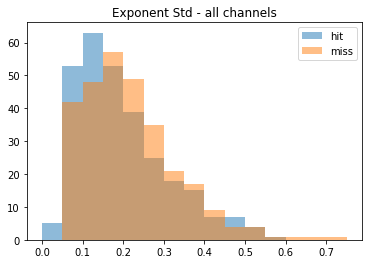

In [65]:
# plot histogram

bins = np.arange(0, 0.8, 0.05)
plt.hist(data_a, alpha=0.5, label='hit', bins=bins)
plt.hist(data_b, alpha=0.5, label='miss', bins=bins)
plt.title("Exponent Std - all channels")
plt.legend()
plt.show()

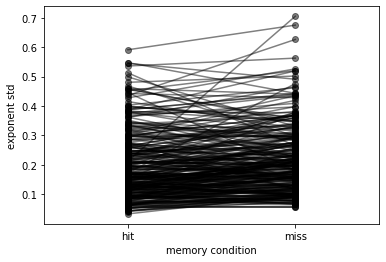

In [67]:
# plot swarm plot

# plot scatter 
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.scatter([0]*len(data_a), data_a, color='k', alpha=0.5)
ax.scatter([1]*len(data_b), data_b, color='k', alpha=0.5)

# connect data points for each subject
for i_sub in range(len(data_a)):
    ax.plot([0, 1], [data_a[i_sub], data_b[i_sub]], 'k-', alpha=0.5)

# label
ax.set_xticks([0, 1])
ax.set_xticklabels(['hit', 'miss'])
ax.set(xlabel="memory condition", ylabel="exponent std")
ax.set_title("Exponent Std - average channels within subject")
ax.set_xlim([-0.5, 1.5])

plt.show()

#### contrast variance of exponent between memory conditions (average channels within subjects)

In [40]:
# run paired ttest (average channels within subject)

df = df_all.copy()
df = df.loc[df['epoch']=='post']
df = df.groupby(['patient','material','memory']).mean()
data_a = df.xs('hit', level=2)['exponent_std']
data_b = df.xs('miss', level=2)['exponent_std'] 
results = ttest_rel(data_a, data_b)
print(results)

Ttest_relResult(statistic=-3.7328194982178076, pvalue=0.0010895982199113504)


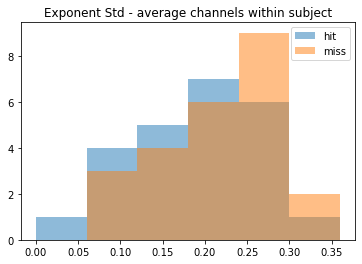

In [50]:
# plot histogram

bins = np.arange(0, 0.4, 0.06)
plt.hist(data_a, alpha=0.5, label='hit', bins=bins)
plt.hist(data_b, alpha=0.5, label='miss', bins=bins)
plt.title("Exponent Std - average channels within subject")
plt.legend()
plt.show()


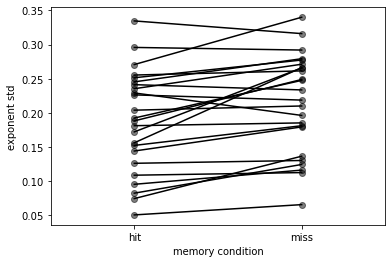

In [53]:
# plot swarm plot

# plot scatter
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.scatter([0]*len(data_a), data_a, color='k', alpha=0.5)
ax.scatter([1]*len(data_b), data_b, color='k', alpha=0.5)

# connect data points for each subject
for i_sub in range(len(data_a)):
    ax.plot([0, 1], [data_a[i_sub], data_b[i_sub]], 'k-')

# label
ax.set_xticks([0, 1])
ax.set_xticklabels(['hit', 'miss'])
ax.set(xlabel="memory condition", ylabel="exponent std")
ax.set_title("Exponent Std - average channels within subject")
ax.set_xlim([-0.5, 1.5])
ax.set_title("")

plt.show()

#### contrast mean of exponent between memory conditions

In [37]:
# run paired ttest - across all subjects (average channels within subject)

for epoch in ['pre','post']:
    for var in ['mean','std']:
        df = df_all.copy()
        df = df.loc[df['epoch']==epoch]
        df = df.groupby(['patient','material','memory']).mean()
        data_a = df.xs('hit', level=2)[f'exponent_{var}']
        data_b = df.xs('miss', level=2)[f'exponent_{var}'] 
        results = ttest_rel(data_a, data_b)
        print(f"\n{epoch}-stimulus exponent {var}")
        print(results)


pre-stimulus exponent mean
Ttest_relResult(statistic=-2.786504981906403, pvalue=0.010490043074257887)

pre-stimulus exponent std
Ttest_relResult(statistic=-2.424092925351262, pvalue=0.02361463976424265)

post-stimulus exponent mean
Ttest_relResult(statistic=-2.5873466098303837, pvalue=0.016469439124711643)

post-stimulus exponent std
Ttest_relResult(statistic=-3.7328194982178076, pvalue=0.0010895982199113504)
